In [ ]:
import os
import sys
sys.path.append('../thermodynamic-interpolation')

import numpy as np
from deeptime.decomposition import TICA
from rembg import remove
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette(sns.color_palette("Dark2", n_colors=10), n_colors=10)
palette = sns.color_palette()
matplotlib.rcParams.update({'font.size': 20})
cmap = 'crest_r'

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_image(img, fig, x_pos=0, y_pos=0, dim=256, remove_bg=False):
    if remove_bg:
        img = remove(img)

    maxsize = (dim, dim)
    img.thumbnail(maxsize)
    
    fig.figimage(img, x_pos, y_pos)

In [ ]:
results_save_path = f"../paper_results/10506_no_300_v2_256_new_scale_1000to300K"
mol_img_path = "mdqm9/plots/frames"

torsions_md_ti_T1 = np.load(f"{results_save_path}/torsions_md_ti_1.npy")
torsions_md_T1 = np.load(f"{results_save_path}/torsions_md_1.npy")
torsions_md_T0 = np.load(f"{results_save_path}/torsions_md_0.npy")
torsions_h5_md = np.load(f"{results_save_path}/torsions_h5_md.npy")

path = "../../gedmd/torsions_larger_molecule/bootstrap_eigenvalues"

md_eigenvalues_mean = np.load(os.path.join(path, "md_eigenvalues_mean.npy")) 
md_eigenvalues_lower = np.load(os.path.join(path, "md_eigenvalues_lower_bound.npy"))  
md_eigenvalues_upper = np.load(os.path.join(path, "md_eigenvalues_upper_bound.npy")) 

bg_eigenvalues_mean = np.load(os.path.join(path, "bg_eigenvalues_mean.npy"))
bg_eigenvalues_lower = np.load(os.path.join(path, "bg_eigenvalues_lower_bound.npy")) 
bg_eigenvalues_upper = np.load(os.path.join(path, "bg_eigenvalues_upper_bound.npy"))   

bg_ti_eigenvalues_mean = np.load(os.path.join(path, "bg_ti_eigenvalues_mean.npy")) 
bg_ti_eigenvalues_lower = np.load(os.path.join(path, "bg_ti_eigenvalues_lower_bound.npy"))
bg_ti_eigenvalues_upper = np.load(os.path.join(path, "bg_ti_eigenvalues_upper_bound.npy"))

md_ti_eigenvalues_mean = np.load(os.path.join(path, "md_ti_eigenvalues_mean.npy"))  
md_ti_eigenvalues_lower = np.load(os.path.join(path, "md_ti_eigenvalues_lower_bound.npy"))
md_ti_eigenvalues_upper = np.load(os.path.join(path, "md_ti_eigenvalues_upper_bound.npy"))

In [4]:
lags = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000])

ticas_md_T0 = np.zeros((len(lags), len(torsions_md_T0), 2))
ticas_md_T1 = np.zeros((len(lags), len(torsions_md_T1), 2))
ticas_md_ti_T1 = np.zeros((len(lags), len(torsions_md_ti_T1), 2))

# encode into features
def enc(x):
    sin = np.sin(x)
    cos = np.cos(x)
    encs = np.stack((cos, sin), axis=-1)
    
    # merge last dimension
    return encs.reshape(encs.shape[0], -1)

enc_h5_md_torsions = enc(torsions_h5_md)
enc_torsions_md_T1 = enc(torsions_md_T1)
enc_torsions_md_T0 = enc(torsions_md_T0)
enc_torsions_md_ti_T1 = enc(torsions_md_ti_T1)

for i, lag in enumerate(lags):
    tica = TICA(lagtime=lag, dim=2)
    tica = tica.fit(enc_h5_md_torsions)#.fetch_model()

    ticas_md_ti_T1[i] = tica.transform(enc_torsions_md_ti_T1)
    ticas_md_T1[i] = tica.transform(enc_torsions_md_T1)
    ticas_md_T0[i] = tica.transform(enc_torsions_md_T0)

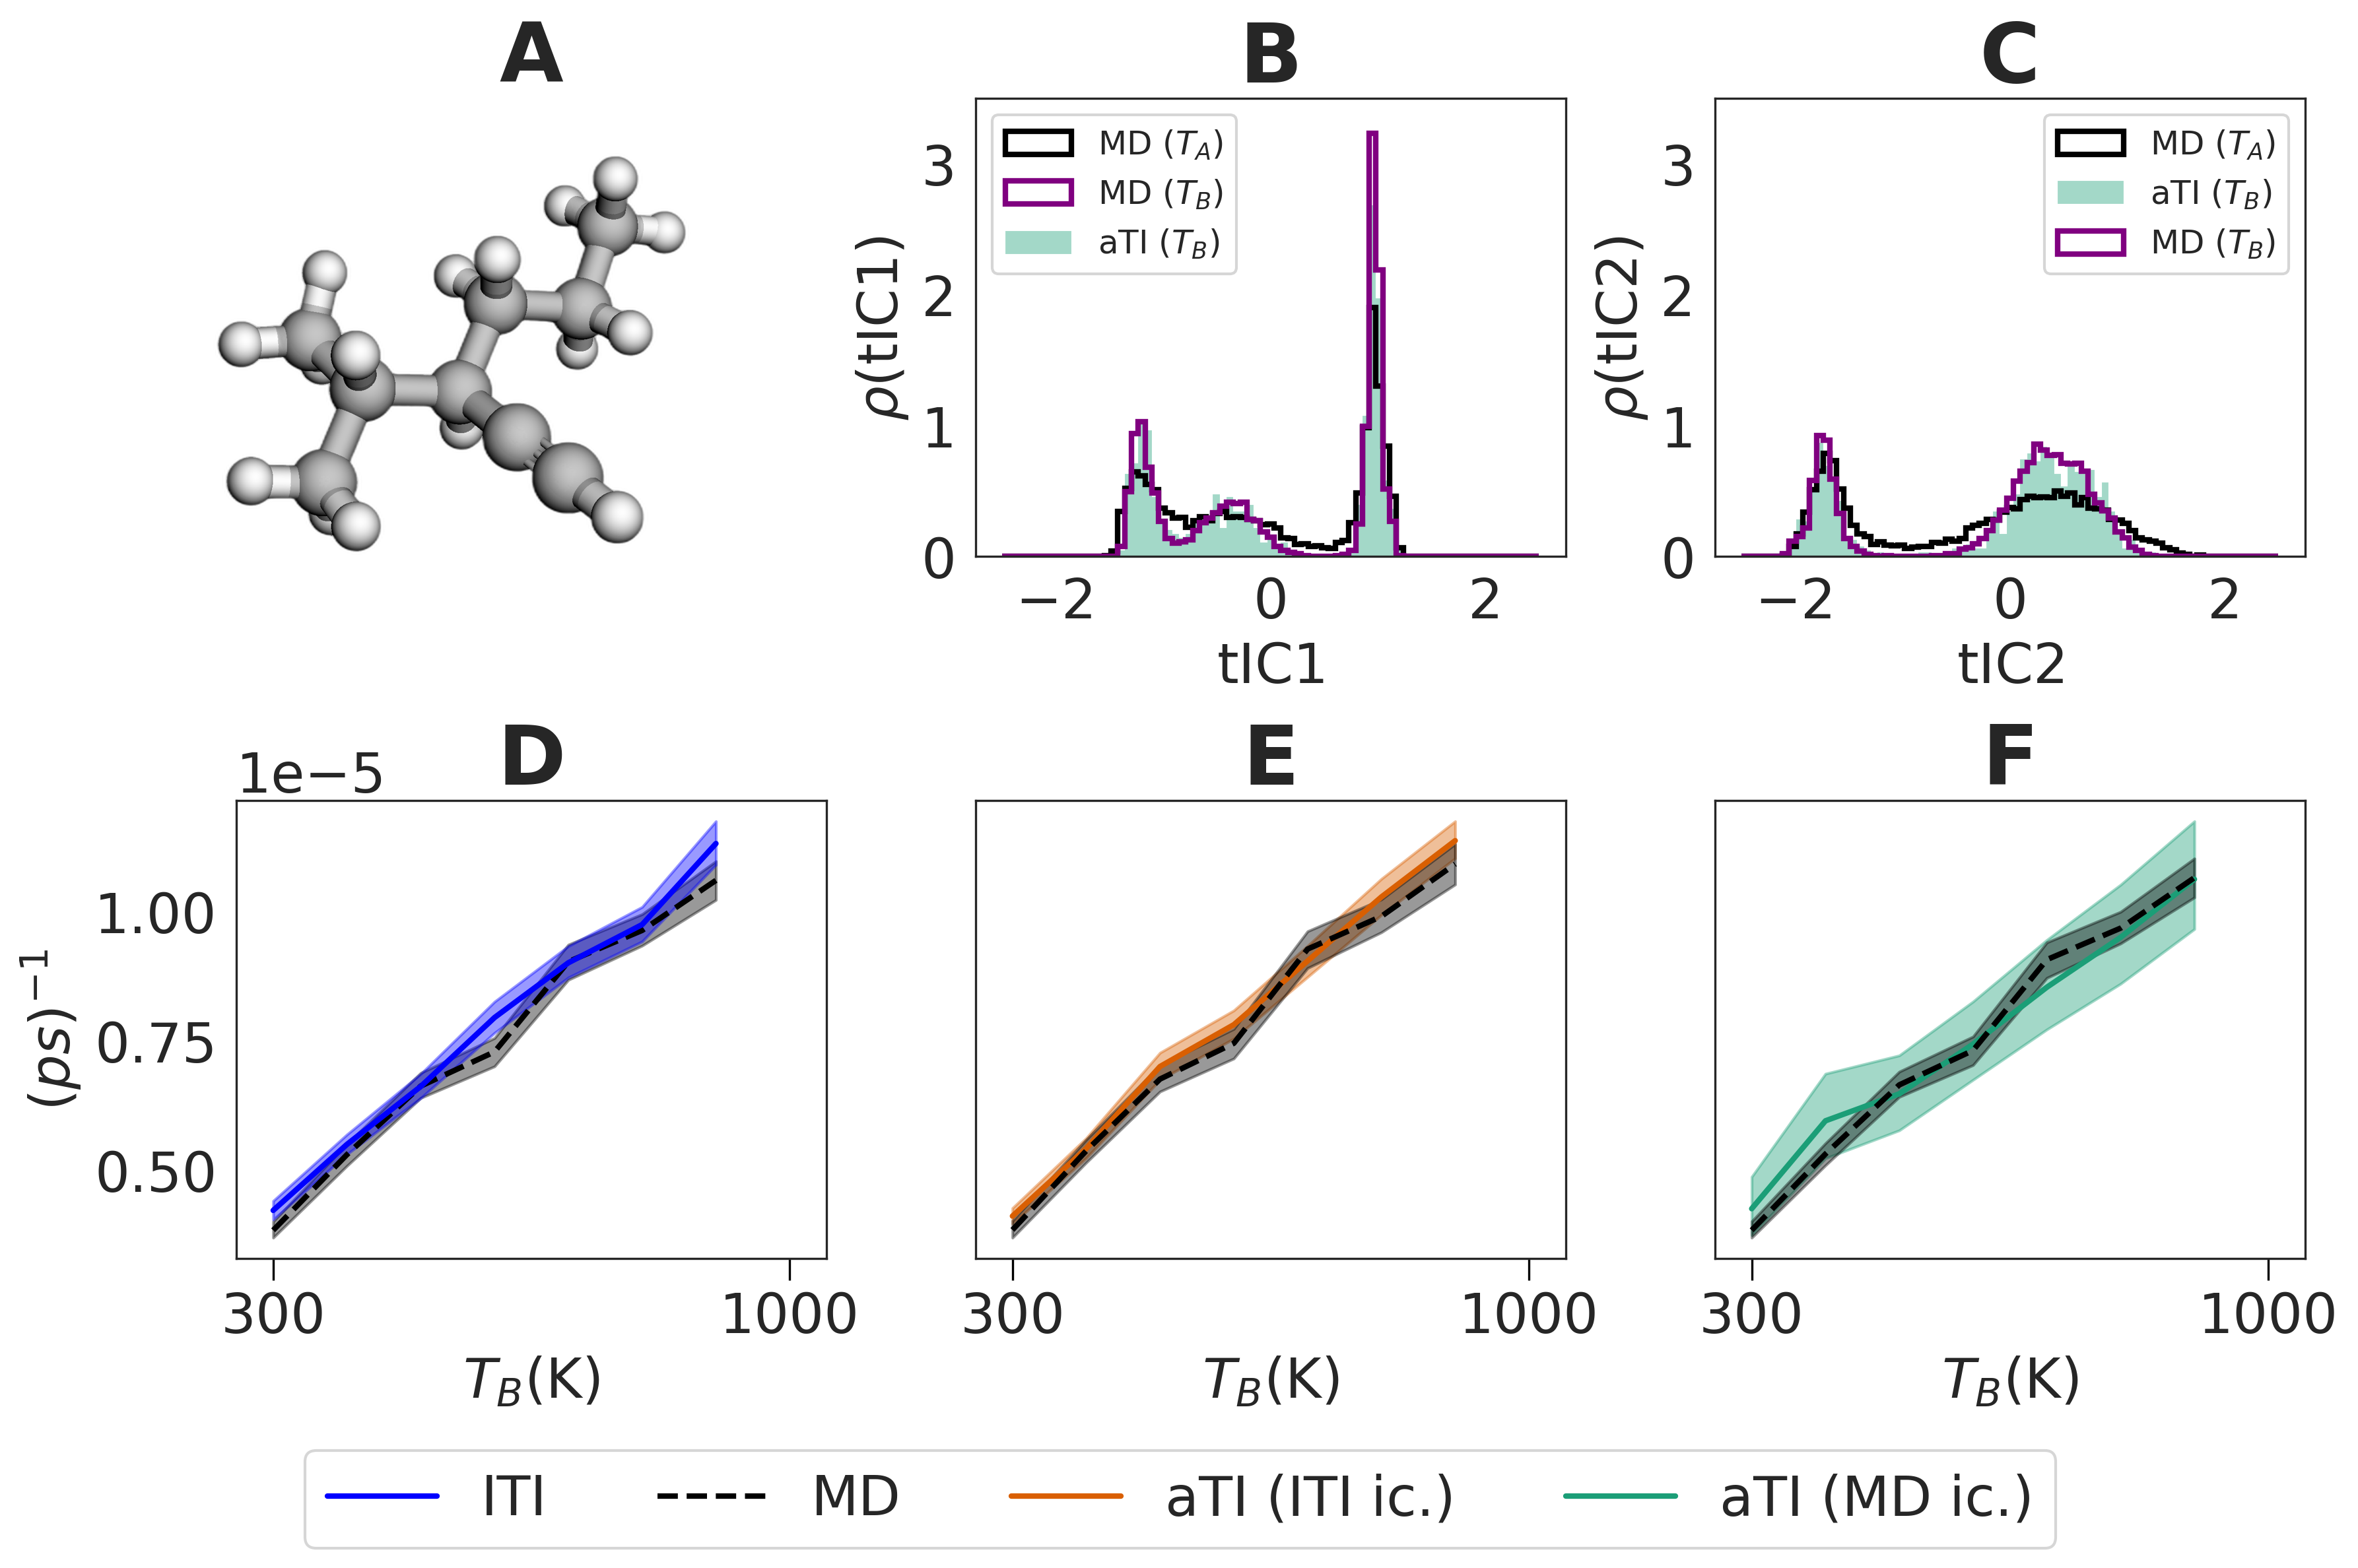

In [8]:
lags = np.array([2])

for i, lag in enumerate(lags):
    # plot
    bins = np.linspace(-2.5, 2.5, 80)

    fig, axs = plt.subplots(3, 3, figsize=(12, 8), dpi=300, height_ratios=[1, 1, 0.1])
    axs = axs.flatten()

    # rm background
    axs[0].axis('off')
    axs[0].set_title("A", fontsize=30, fontweight="bold")

    img = Image.open(f"{mol_img_path}/big_mol.png")
    dim = 900
    plot_image(img=img, fig=fig, x_pos=250, y_pos=1500, dim=dim, remove_bg=True)

    axs[1].hist(ticas_md_T0[i][:, 0], bins=bins, histtype="step", color='k', density=True, label=r"MD $(T_A)$", linewidth=2)
    axs[1].hist(ticas_md_T1[i][:, 0], bins=bins, histtype="step", color='purple', density=True, label=r"MD $(T_B)$", linewidth=2)
    axs[1].hist(ticas_md_ti_T1[i][:, 0], bins=bins, histtype="stepfilled", alpha=0.4, color=palette[0], density=True, label=r"aTI $(T_B)$", linewidth=0.1)

    axs[1].set_xlabel(r"$\mathrm{tIC1}$")
    axs[1].set_ylabel(r"$\rho(\mathrm{tIC1})$")
    axs[1].set_ylim([0, 3.5])
    axs[1].set_yticks([0, 1, 2, 3])
    axs[1].set_title("B", fontsize=30, fontweight="bold")
    axs[1].legend(fontsize=12)

    axs[2].hist(ticas_md_T0[i][:, 1], bins=bins, histtype="step", color='k', density=True, label=r"MD $(T_A)$", linewidth=2)
    axs[2].hist(ticas_md_ti_T1[i][:, 1], bins=bins, histtype="stepfilled", alpha=0.4, color=palette[0], density=True, label=r"aTI $(T_B)$", linewidth=0.1)
    axs[2].hist(ticas_md_T1[i][:, 1], bins=bins, histtype="step", color='purple', density=True, label=r"MD $(T_B)$", linewidth=2)

    axs[2].set_xlabel(r"$\mathrm{tIC2}$")
    axs[2].set_ylabel(r"$\rho(\mathrm{tIC2})$")
    axs[2].set_ylim([0, 3.5])
    axs[2].set_yticks([0, 1, 2, 3])
    axs[2].set_title("C", fontsize=30, fontweight="bold")
    axs[2].legend(fontsize=12)


    # BG
    Ts = [300, 400, 500, 600, 700, 800, 900]
    T0 = 1000
    axs[3].plot(Ts, md_eigenvalues_mean[:,3], label='MD', color='k', linewidth=2, linestyle='--')
    axs[3].fill_between(Ts, md_eigenvalues_lower[:,3], md_eigenvalues_upper[:,3], alpha=0.4, color='k')
    axs[3].plot(Ts, bg_eigenvalues_mean[:,3], label='ITI', color='b', linewidth=2)
    axs[3].fill_between(Ts, bg_eigenvalues_lower[:, 3], bg_eigenvalues_upper[:, 3], alpha=0.4, color='b')

    axs[3].set_title("D", fontsize=30, weight='bold')
    axs[3].set_xticks([300, 1000])
    axs[3].set_xlim([250, 1050])
    axs[3].tick_params(bottom=True, top=False, axis='x', color='k', length=8, grid_color='none')
    # axs[3].axvline(T0, color='k', linestyle='--', linewidth=3)
    # make major ticks visible
    axs[3].set_xlabel(r'$T_B$(K)')
    axs[3].set_ylabel(r'$(ps)^{-1}$')


    # BG/TI
    axs[4].plot(Ts, bg_ti_eigenvalues_mean[:,3], label='aTI (ITI ic.)', color=palette[1], linewidth=2)
    axs[4].fill_between(Ts, bg_ti_eigenvalues_lower[:,3], bg_ti_eigenvalues_upper[:,3], alpha=0.4, color=palette[1])
    # reference
    axs[4].plot(Ts, md_eigenvalues_mean[:,3], label='MD', color='k', linewidth=2, linestyle='--')
    axs[4].fill_between(Ts, md_eigenvalues_lower[:,3], md_eigenvalues_upper[:,3], alpha=0.4, color='k')
    axs[4].set_title("E", fontsize=30, weight='bold')
    axs[4].set_xticks([300, 1000])
    axs[4].set_xlim([250, 1050])
    axs[4].tick_params(bottom=True, top=False, axis='x', color='k', length=8, grid_color='none')
    axs[4].set_xlabel(r'$T_B$(K)')
    # axs[4].axvline(T0, color='k', linestyle='--', linewidth=3)
    # axs[1].set_ylabel(r'$\kappa$')
    axs[4].set_yticklabels([])

    # MD/TI
    axs[5].plot(Ts, md_ti_eigenvalues_mean[:,3], label='aTI (MD ic.)', color=palette[0], linewidth=2)
    axs[5].fill_between(Ts, md_ti_eigenvalues_lower[:,3], md_ti_eigenvalues_upper[:,3], alpha=0.4, color=palette[0])
    # reference
    axs[5].plot(Ts, md_eigenvalues_mean[:,3], label='MD', color='k', linewidth=2, linestyle='--')
    axs[5].fill_between(Ts, md_eigenvalues_lower[:,3], md_eigenvalues_upper[:,3], alpha=0.4, color='k')
                        
    axs[5].set_title("F", fontsize=30, weight='bold')
    axs[5].set_xticks([300, 1000])
    axs[5].set_xlim([250, 1050])
    axs[5].tick_params(bottom=True, top=False, axis='x', color='k', length=8, grid_color='none')
    axs[5].set_xlabel(r'$T_B$(K)')
    # axs[5].axvline(T0, color='k', linestyle='--', linewidth=3)
    # axs[2].set_ylabel(r'$\kappa$')
    axs[5].set_yticklabels([])


    lines_labels = [axs[3].get_legend_handles_labels(), axs[4].get_legend_handles_labels(), axs[5].get_legend_handles_labels()] #[axs[i].get_legend_handles_labels() for i in range(len(axs))]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    lines_labels = {label: line for line, label in zip(lines, labels)}
    labels = sorted(list(lines_labels.keys()))
    lines = [lines_labels[label] for label in labels]

    # fig.suptitle(f"TICA - Lag Time: {lag}", fontsize=20, weight='bold')
    fig.legend(lines, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, 0), fontsize=20)
    
    axs[6].axis('off')
    axs[7].axis('off')
    axs[8].axis('off')
    plt.tight_layout(pad=0.5)
    plt.savefig(f"{results_save_path}/big_mol_results.pdf")
